In [1]:
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Resizing, Rescaling, Reshape
from tensorflow.keras.utils import Sequence
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from tqdm import tqdm
import seaborn as sns

from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Input, InputLayer, Normalization, Flatten,BatchNormalization, Dropout,Conv2D, GlobalAveragePooling2D, MaxPool2D, ReLU, Layer,Activation, Multiply, AveragePooling2D, Add
from tensorflow.keras import layers as L
from tensorflow.keras import backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from tensorflow.keras.backend import clear_session
from tensorflow.keras.optimizers import RMSprop, SGD, Adam

from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
from tensorflow.keras.datasets.cifar10 import load_data
from tensorflow.keras.optimizers.schedules import *
from tensorflow.keras.metrics import FalseNegatives, binary_crossentropy, binary_accuracy, categorical_crossentropy, sparse_categorical_crossentropy
from tensorflow.keras.regularizers import l2
from IPython.display import Audio, display
import math

from tensorflow.keras.utils import plot_model

In [2]:
# class DataGenerator(keras.utils.Sequence):
#     'Generates data for Keras'
#     def __init__(self, list_IDs, labels, batch_size=32, dim=(32,32,32), n_channels=1,
#                  n_classes=10, shuffle=True):
#         'Initialization'
#         self.dim = dim
#         self.batch_size = batch_size
#         self.labels = labels
#         self.list_IDs = list_IDs
#         self.n_channels = n_channels
#         self.n_classes = n_classes
#         self.shuffle = shuffle
#         self.on_epoch_end()

#     def __len__(self):
#         'Denotes the number of batches per epoch'
#         return int(np.floor(len(self.list_IDs) / self.batch_size))

#     def __getitem__(self, index):
#         'Generate one batch of data'
#         # Generate indexes of the batch
#         indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

#         # Find list of IDs
#         list_IDs_temp = [self.list_IDs[k] for k in indexes]

#         # Generate data
#         X, y = self.__data_generation(list_IDs_temp)

#         return X, y

#     def on_epoch_end(self):
#         'Updates indexes after each epoch'
#         self.indexes = np.arange(len(self.list_IDs))
#         if self.shuffle == True:
#             np.random.shuffle(self.indexes)

#     def __data_generation(self, list_IDs_temp):
#         'Generates data containing batch_size samples' # X : (n_samples, *dim, n_channels)
#         # Initialization
#         X = np.empty((self.batch_size, *self.dim, self.n_channels))
#         y = np.empty((self.batch_size), dtype=int)

#         # Generate data
#         for i, ID in enumerate(list_IDs_temp):
#             # Store sample
#             X[i,] = np.load('data/' + ID + '.npy')

#             # Store class
#             y[i] = self.labels[ID]

#         return X, keras.utils.to_categorical(y, num_classes=self.n_classes)

In [3]:
(X_train, y_train), (X_test, y_test) = load_data()

y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [4]:
class ResNet:
    @staticmethod
    def residual_module(data, K, stride, chanDim, red=False,
        reg=0.0001, bnEps=2e-5, bnMom=0.9):
        # the shortcut branch of the ResNet module should be
        # initialize as the input (identity) data
        shortcut = data

        # the first block of the ResNet module are the 1x1 CONVs
        bn1 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(data)
        act1 = Activation("relu")(bn1)
        conv1 = Conv2D(int(K * 0.25), (1, 1), use_bias=False,
            kernel_regularizer=l2(reg))(act1)

        # the second block of the ResNet module are the 3x3 CONVs
        bn2 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(conv1)
        act2 = Activation("relu")(bn2)
        conv2 = Conv2D(int(K * 0.25), (3, 3), strides=stride,
            padding="same", use_bias=False,
            kernel_regularizer=l2(reg))(act2)

        # the third block of the ResNet module is another set of 1x1
        # CONVs
        bn3 = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(conv2)
        act3 = Activation("relu")(bn3)
        conv3 = Conv2D(K, (1, 1), use_bias=False,
            kernel_regularizer=l2(reg))(act3)

        # if we are to reduce the spatial size, apply a CONV layer to
        # the shortcut
        if red:
            shortcut = Conv2D(K, (1, 1), strides=stride,
                use_bias=False, kernel_regularizer=l2(reg))(act1)

        # add together the shortcut and the final CONV
        x = add([conv3, shortcut])

        # return the addition as the output of the ResNet module
        return x

    @staticmethod
    def build(width, height, depth, classes, stages, filters,
        reg=0.0001, bnEps=2e-5, bnMom=0.9, dataset="cifar"):
        # initialize the input shape to be "channels last" and the
        # channels dimension itself
        inputShape = (height, width, depth)
        chanDim = -1

        # if we are using "channels first", update the input shape
        # and channels dimension
        if K.image_data_format() == "channels_first":
            inputShape = (depth, height, width)
            chanDim = 1

        # set the input and apply BN
        inputs = Input(shape=inputShape)
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(inputs)

        # apply a single CONV layer
        x = Conv2D(filters[0], (3, 3), use_bias=False,
            padding="same", kernel_regularizer=l2(reg))(x)

        # loop over the number of stages
        for i in range(0, len(stages)):
            # initialize the stride, then apply a residual module
            # used to reduce the spatial size of the input volume
            stride = (1, 1) if i == 0 else (2, 2)
            x = ResNet.residual_module(x, filters[i + 1], stride,
                chanDim, red=True, bnEps=bnEps, bnMom=bnMom)

            # loop over the number of layers in the stage
            for j in range(0, stages[i] - 1):
                # apply a ResNet module
                x = ResNet.residual_module(x, filters[i + 1],
                    (1, 1), chanDim, bnEps=bnEps, bnMom=bnMom)

        # apply BN => ACT => POOL
        x = BatchNormalization(axis=chanDim, epsilon=bnEps,
            momentum=bnMom)(x)
        x = Activation("relu")(x)
        x = AveragePooling2D((8, 8))(x)

        # softmax classifier
        x = Flatten()(x)
        x = Dense(classes, kernel_regularizer=l2(reg))(x)
        x = Activation("softmax")(x)

        # create the model
        model = Model(inputs, x, name="resnet")

        # return the constructed network architecture
        return model

In [5]:
class Baseline:
    def __init__(self, inputs) -> None:
        self.inputs = inputs
        self.normalize = Normalization()
        self.optimizer = Adam(learning_rate=0.5)
        self.dense1 = Dense(1028, activation = 'relu')
        self.dense2 = Dense(128, activation='relu')
        self.dense3 = Dense(128, activation='relu')
        self.dense4 = Dense(10, activation ='softmax')
        self.dropout = tf.keras.layers.Dropout(0.2)
        self.model = Model
    def call(self, training = False):
        self.normalize.adapt(X_train)
        x= self.normalize(self.inputs)
        x = Flatten()(x)
        x = self.dense1(x)
        x = self.dense2(x)
        x = self.dense3(x)
        x = self.dense4(x)
        if training:
            x = self.dropout(x, training=training)
        return self.model(inputs = self.inputs, outputs = x)
    def print(self):
        model = self.call()
        print(model.summary())
    def compile(self):
        model = self.call()
        model.compile(optimizer = self.optimizer, loss = 'mean_squared_error', metrics='accuracy')
        return model

In [6]:
WEIGHT_DECAY = 0.0005

In [7]:
class WideResBlock(Model):
    """wide residual block"""
    def __init__(self, out_channels, block_num, layer_num, activation = 'relu'):
        super(WideResBlock, self).__init__(name='block'+'_'+str(block_num)+'_'+str(layer_num))       
         
        block_name = '_'+str(block_num)+'_'+str(layer_num)
        
        if block_num == 1:
            stride = 1
            self.conv_sc = Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False, kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')
            self.bn_sc = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
        elif layer_num == 0:
            stride = 2
            self.conv_sc = Conv2D(out_channels, kernel_size=1, strides=stride, padding='same', use_bias=False, kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')
            self.bn_sc = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
        else:
            stride = 1

        self.activation = Activation(activation)
        self.bn1 = BatchNormalization(epsilon=1e-5, gamma_initializer='uniform')
        self.dropout = Dropout(rate=0.3)
        
        self.conv1 = Conv2D(out_channels, kernel_size=3, strides=stride, padding='same',use_bias=False, kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')
        self.bn2 = BatchNormalization()
        self.conv2 = Conv2D(out_channels, kernel_size=3, strides=1, padding='same', use_bias=False, kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')

        self.add = Add()
        self.layer_num = layer_num
        self.block_num = block_num

    def call(self, x):
        out = self.bn1(x)
        out = self.activation(out)

        out = self.conv1(out)
        out = self.bn2(out)
        out = self.activation(out)
        out = self.dropout(out)
        out = self.conv2(out)
        try:
            shortcut = self.conv_sc(x)
            # shortcut = self.bn_sc(shortcut)
        except:
            shortcut = x
        out = self.add([out, shortcut])
        return out

In [8]:
class WideResNet(Model):
    def __init__(self, depth, k, num_classes=10):
        super().__init__()
        self._layers = []
        N = (depth - 4) // 6
        self._layers += [
            Normalization()
        ]
        self._layers += [
            Conv2D(filters = 16, kernel_size = 3, kernel_regularizer=l2(WEIGHT_DECAY), use_bias=False, kernel_initializer='he_normal')
        ]

        # Residual block
        self._layers += [WideResBlock(out_channels=16*k, block_num=1, layer_num=i) for i in range(N)]
        self._layers += [WideResBlock(out_channels=32*k, block_num=2, layer_num=i) for i in range(N)]
        self._layers += [WideResBlock(out_channels=64*k, block_num=3, layer_num=i) for i in range(N)]

        self._layers += [
            BatchNormalization(name='bn_input'),
            Activation('relu', name='act_input'),
            GlobalAveragePooling2D(name='pool_output'),
            Dense(num_classes, activation='softmax', name='output', kernel_regularizer=l2(WEIGHT_DECAY), kernel_initializer='he_normal')
        ]

    def call(self, x):
        for layer in self._layers:
            x = layer(x)
        return x
model = WideResNet(depth=28, k=10, num_classes=10)
dummy_input = Input(shape=(32, 32, 3)) 
model_summary = Model(inputs=[dummy_input], outputs=model.call(dummy_input))
# plot_model(model_summary)
model_summary.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 normalization (Normalizatio  (None, 32, 32, 3)        7         
 n)                                                              
                                                                 
 conv2d (Conv2D)             (None, 30, 30, 16)        432       
                                                                 
 block_1_0 (WideResBlock)    (None, 30, 30, 160)       256704    
                                                                 
 block_1_1 (WideResBlock)    (None, 30, 30, 160)       487680    
                                                                 
 block_1_2 (WideResBlock)    (None, 30, 30, 160)       487680    
                                                             

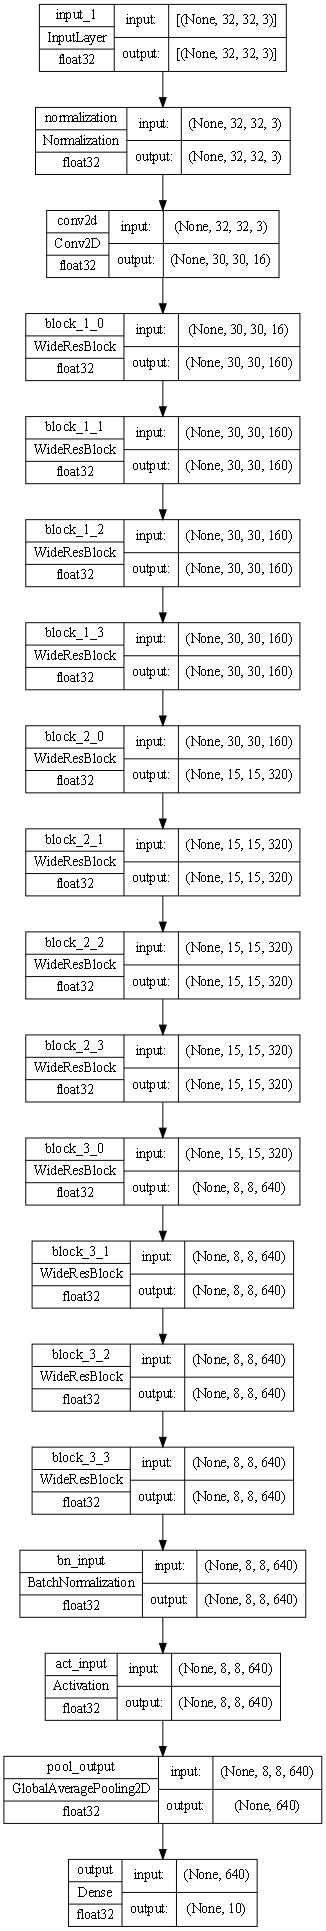

In [16]:
# model_name = '{}'.format(time.strftime("%Y%m%d%H%M%S"))
# model_path = 'models/{}/'.format(model_name)
# model_weights = os.path.join(model_path, 'model.h5')
# model_logs = os.path.join(model_path, 'training.csv')
# model_preds = os.path.join(model_path, 'preds.npy')
# callbacks = [EarlyStopping(monitor='val_loss',
#                            patience=10,
#                            verbose=1,
#                            min_delta=0.00001,
#                            mode='min'),
#              ReduceLROnPlateau(monitor='val_loss',
#                                factor=0.1,
#                                patience=4,
#                                verbose=1,
#                                epsilon=0.0001,
#                                mode='min'),
#              ModelCheckpoint(monitor='val_loss',
#                              filepath=model_weights,
#                              save_best_only=True,
#                              save_weights_only=False,
#                              mode='min'),
#              TensorBoard(log_dir=model_path),
#              CSVLogger(model_logs,
#                        separator=',',
#                        append=False),
#              ]
from tensorflow.keras.utils import plot_model
plot_model(model_summary, show_shapes=True, show_dtype=True,
    show_layer_names=True, expand_nested=True, dpi=70)